# Test models

## Initialization

In [ ]:
import os
import pyvdirs.dirs as dirs
import sys
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))
from socket import gethostname

import torch
import numpy as np
import json
import matplotlib.pyplot as plt

from ToyExample.toy_example import do_test
import pyvtools.text as vtext
import ours.utils as utils

### Parameters

In [317]:
test_batch_size = 10*2**14
test_n_samples = 10*2**14
test_seed = 7

# series = ["18_Statistics", "19_ACIDParams", "21_Repetitions", "23_NormalizedLogits"]
# series = ["25_ACIDParams_00"]
# series = ["23_NormalizedLogits"]
series = ["28_Test_Size"]

# results_filename = "TestResults_25_ACIDParams_00.json"
# results_filename = "TestResults_23.json"
# results_filename = "TestResults_28.json"
results_filename = "TestResults_24_01_16k.json"

### Auxiliary definitions

In [ ]:
get_path = lambda series : os.path.join(dirs.MODELS_HOME, "ToyExample", series)

host_id = gethostname()
other_hosts = vtext.filter_by_string_must(list(dirs.check_directories_file().keys()), [host_id,"else"], must=False)

results_filepath = os.path.join(dirs.RESULTS_HOME, "ToyExample", results_filename)

series_folders = {}
for s in series:
    series_path = get_path(s)
    contents = os.listdir(series_path)
    folders = [c for c in contents if os.path.isdir(os.path.join(series_path, c))]
    folders = vtext.filter_by_string_must(folders, ["Failed", "Old", "Others"], must=False)
    series_folders[s] = folders

In [319]:
series_folders

{'28_Test_Size': ['EarlyACIDNonInverted_000',
  'EarlyACIDNonInverted_073',
  'EarlyACIDNonInverted_172',
  'EarlyACIDNonInverted_231',
  'EarlyACIDNonInverted_357',
  'NoACID_000',
  'NoACID_073',
  'NoACID_172',
  'NoACID_231',
  'NoACID_357']}

## Run test and collect results

### If needed, run

In [293]:
test_results = {}

for s in series:

    series_path = get_path(s)
    log_files = ["log_"+f+".txt" for f in series_folders[s]]
    assert all([os.path.isfile(os.path.join(series_path, f)) for f in log_files]), "Some logs have not been found"

    test_results[s] = {}
    for folder, log_file in zip(series_folders[s], log_files):

        log_filepath = os.path.join(series_path, log_file)

        files = os.listdir(os.path.join(series_path, folder))
        net_file = vtext.filter_by_string_must(files, "learner")[0]
        EMA_file = "".join(net_file.split("learner"))

        net_filepath = os.path.join(series_path, folder, net_file)
        EMA_filepath = os.path.join(series_path, folder, EMA_file)

        with open(log_filepath, "r") as f:
            acid = False
            for i, line in enumerate(f):
                if "ACID = True" in line:
                    acid = True
                if "Guide model loaded from" in line or i>70: 
                    break
        if "Guide model loaded from" in line:
            guide_line = line
            guide_filepath = guide_line.split("Guide model loaded from ")[-1].split("\n")[0]
            for h in other_hosts:
                guide_filepath = guide_filepath.replace(dirs.check_directories_file()[h]["models_home"], dirs.MODELS_HOME)
        else:
            guide_filepath = None

        folder_results = do_test(
            net_filepath, ema_path=EMA_filepath, guide_path=guide_filepath, acid=acid, 
            classes='A', P_mean=-2.3, P_std=1.5, sigma_max=5, depth_sep=5,
            n_samples=test_n_samples, batch_size=test_batch_size, 
            test_outer=True, test_mandala=True,
            guidance_weight=3,
            seed=test_seed, generator=None,
            log_filename=log_filepath,
            device=torch.device('cuda'))
        
        test_results[s][folder] = folder_results

2025-05-28 09:15 | INFO     | Seed = 7
2025-05-28 09:15 | INFO     | Number of test epochs = 1
2025-05-28 09:15 | INFO     | Test batch size = 163840
2025-05-28 09:15 | INFO     | Number of test samples = 163840
100%|██████████| 1/1 [01:26<00:00, 86.30s/it]


In [294]:
with open(results_filepath, "w") as file:
    json.dump({"test_n_samples":test_n_samples,
               "test_batch_size":test_batch_size,
    json.dump({"test_n_samples":test_n_samples,
               "test_batch_size":test_batch_size,
               "test_seed":test_seed,
               **test_results}, 
               file)

### If not needed, then load

In [320]:
with open(results_filepath, "r") as file:
    test_results = json.load(file)

In [ ]:
test_batch_size = test_results.pop("test_batch_size")
try: test_n_samples = test_results.pop("test_n_samples")
except KeyError: test_n_samples = test_batch_size
test_seed = test_results.pop("test_seed")

In [325]:
series = list(test_results.keys())

series_folders = {}
for s in series:
    series_path = get_path(s)
    contents = os.listdir(series_path)
    folders = [c for c in contents if os.path.isdir(os.path.join(series_path, c))]
    folders = vtext.filter_by_string_must(folders, ["Failed", "Old", "Others"], must=False)
    series_folders[s] = folders
del folders

### In case you need to combine two...

In [ ]:
with open(results_filepath, "r") as file:
    test_results_old = json.load(file)
    test_batch_size_old = test_results_old.pop("test_batch_size")
    test_seed_old = test_results_old.pop("test_seed")

    series_old = list(test_results_old.keys())

    series_folders_old = {}
    for s in series_old:
        series_path = get_path(s)
        contents = os.listdir(series_path)
        folders = [c for c in contents if os.path.isdir(os.path.join(series_path, c))]
        folders = vtext.filter_by_string_must(folders, ["Failed", "Old", "Others"], must=False)
        series_folders_old[s] = folders
    del folders, contents, series_path

assert test_batch_size == test_batch_size_old, "Beware! Different batch size"
assert test_seed == test_seed_old, "Beware! Different seed"

In [ ]:
# test_results["23_NormalizedLogits"] = test_results["23_NormalizedLogits_02"]
# del test_results["23_NormalizedLogits_02"]

In [ ]:
for s in test_results_old.keys():
    try:
        test_results[s].update(test_results_old[s])
    except KeyError:
        test_results[s] = test_results_old[s]

In [ ]:
with open(results_filepath.split(".json")[0]+"_Combined.json", "w") as file:
    json.dump({"test_batch_size":test_batch_size,
               "test_seed":test_seed,
               **test_results}, 
               file)

## Process data

### Get keys and fill gaps

In [262]:
test_keys = set()
for s in series:
    for folder in test_results[s].keys():
        test_keys.update( list(test_results[s][folder].keys()) )

In [263]:
for test_key in test_keys:
    for s in series:
        for folder_key, vals in test_results[s].items():
            if test_key not in vals.keys():
                test_results[s][folder_key][test_key] = None

In [264]:
sorted_results = {test_key: {s: {f: test_results[s][f][test_key] for f in test_results[s].keys()} for s in test_results.keys()} for test_key in test_keys}

In [156]:
test_names = {
    "ema_loss":"EMA's Average Loss",
    "ema_out_loss":"EMA's Outer Average Loss",
    "learner_loss":"Learner's Average Loss",
    "learner_out_loss":"Learner's Outer Average Loss",
    "ref_loss":"Reference's Average Loss",
    "ref_out_loss":"Reference's Outer Average Loss",
    "guide_loss":"Guide's Average Loss",
    "guide_out_loss":"Guide's Outer Average Loss",
    "ema_L2_metric":"EMA's Average L2 Distance",
    "ema_out_L2_metric":"EMA's Outer Average L2 Distance",
    "learner_L2_metric":"Learner's Average L2 Distance",
    "learner_out_L2_metric":"Learner's Outer Average L2 Distance",
    "ema_guided_L2_metric":"Guided EMA's Average L2 Distance",
    "ema_guided_out_L2_metric":"Guided EMA's Outer Average L2 Distance",
    "learner_guided_L2_metric":"Guided Learner's Average L2 Distance",
    "learner_guided_out_L2_metric":"Guided Learner's Outer Average L2 Distance",
    "ema_mandala_score":"EMA's Mandala Score",
    "learner_mandala_score":"Learner's Mandala Score",
    "ema_guided_mandala_score":"Guided EMA's Mandala Score",
    "learner_guided_mandala_score":"Guided Learner's Mandala Score",
    "ema_classification_score":"EMA's Classification Score",
    "learner_classification_score":"Learner's Classification Score",
    "ema_guided_classification_score":"Guided EMA's Classification Score",
    "learner_guided_classification_score":"Guided Learner's Classification Score",
}
assert all([test_key in test_names.keys() for test_key in test_keys]), "Missing key"

In [157]:
test_keys = list(test_names.keys())
sorted_results = {test_key:sorted_results[test_key] for test_key in test_keys}

In [158]:
label_series = {}
for s in series:
    label_series[s] = {}
    for f in series_folders[s]:
        label = " ".join(utils.split_camel_case(f))
        label = label.replace("No ACID", "Autoguidance")
        if "Non Inverted" in label:
            label = label.replace("ACID Non Inverted", "ACID")
        else:
            label = label.replace("ACID", "iACID")
        label = label.replace("Interpol ", "p")
        label = label.replace("ACID", "AJEST")
        label_series[s][f] = label
label_series

{'24_Statistics': {'ACIDNonInverted_000': 'AJEST_000',
  'ACIDNonInverted_073': 'AJEST_073',
  'ACIDNonInverted_172': 'AJEST_172',
  'ACIDNonInverted_231': 'AJEST_231',
  'ACIDNonInverted_357': 'AJEST_357',
  'ACID_000': 'iAJEST_000',
  'ACID_073': 'iAJEST_073',
  'ACID_172': 'iAJEST_172',
  'ACID_231': 'iAJEST_231',
  'ACID_357': 'iAJEST_357',
  'EarlyACIDNonInverted_000': 'Early AJEST_000',
  'EarlyACIDNonInverted_073': 'Early AJEST_073',
  'EarlyACIDNonInverted_172': 'Early AJEST_172',
  'EarlyACIDNonInverted_231': 'Early AJEST_231',
  'EarlyACIDNonInverted_357': 'Early AJEST_357',
  'LateACIDNonInverted_073': 'Late AJEST_073',
  'EarlyACID_000': 'Early iAJEST_000',
  'EarlyACID_073': 'Early iAJEST_073',
  'EarlyACID_172': 'Early iAJEST_172',
  'EarlyACID_231': 'Early iAJEST_231',
  'EarlyACID_357': 'Early iAJEST_357',
  'LateACIDNonInverted_000': 'Late AJEST_000',
  'LateACIDNonInverted_172': 'Late AJEST_172',
  'LateACIDNonInverted_231': 'Late AJEST_231',
  'LateACIDNonInverted_35

In [159]:
class_series = {}
for s in series:
    class_series[s] = {}
    for f in series_folders[s]:
        class_series[s][f] = {}
        if label_series[s][f].startswith("Early"):
            class_series[s][f]["When"] = 0
        elif label_series[s][f].startswith("Late"):
            class_series[s][f]["When"] = 1
        else:
            class_series[s][f]["When"] = 2
        if "iAJEST" in label_series[s][f]:
            class_series[s][f]["Inverted"] = 1
        else:
            class_series[s][f]["Inverted"] = 0
        if label_series[s][f]=="Autoguidance":
            class_series[s][f]["Method"] = 0
        elif "Interpol" in f:
            class_series[s][f]["Method"] = 2
        else:
            class_series[s][f]["Method"] = 1
class_series

{'24_Statistics': {'ACIDNonInverted_000': {'When': 2,
   'Inverted': 0,
   'Method': 1},
  'ACIDNonInverted_073': {'When': 2, 'Inverted': 0, 'Method': 1},
  'ACIDNonInverted_172': {'When': 2, 'Inverted': 0, 'Method': 1},
  'ACIDNonInverted_231': {'When': 2, 'Inverted': 0, 'Method': 1},
  'ACIDNonInverted_357': {'When': 2, 'Inverted': 0, 'Method': 1},
  'ACID_000': {'When': 2, 'Inverted': 1, 'Method': 1},
  'ACID_073': {'When': 2, 'Inverted': 1, 'Method': 1},
  'ACID_172': {'When': 2, 'Inverted': 1, 'Method': 1},
  'ACID_231': {'When': 2, 'Inverted': 1, 'Method': 1},
  'ACID_357': {'When': 2, 'Inverted': 1, 'Method': 1},
  'EarlyACIDNonInverted_000': {'When': 0, 'Inverted': 0, 'Method': 1},
  'EarlyACIDNonInverted_073': {'When': 0, 'Inverted': 0, 'Method': 1},
  'EarlyACIDNonInverted_172': {'When': 0, 'Inverted': 0, 'Method': 1},
  'EarlyACIDNonInverted_231': {'When': 0, 'Inverted': 0, 'Method': 1},
  'EarlyACIDNonInverted_357': {'When': 0, 'Inverted': 0, 'Method': 1},
  'LateACIDNonInv

In [160]:
for s in series:
    when = [class_series[s][f]["When"] for f in series_folders[s]]
    method = [class_series[s][f]["Method"] for f in series_folders[s]]
    inverted = [class_series[s][f]["Inverted"] for f in series_folders[s]]
    series_folders[s] = [series_folders[s][idx] for idx in np.lexsort((inverted, when, method))]

sorted_results = {k: {s: {f: sorted_results[k][s][f] for f in series_folders[s]} for s in series} for k in test_keys}
label_series = {s: {f: label_series[s][f] for f in series_folders[s]} for s in series}
label_series

{'24_Statistics': {'EarlyACIDNonInverted_000': 'Early AJEST_000',
  'EarlyACIDNonInverted_073': 'Early AJEST_073',
  'EarlyACIDNonInverted_172': 'Early AJEST_172',
  'EarlyACIDNonInverted_231': 'Early AJEST_231',
  'EarlyACIDNonInverted_357': 'Early AJEST_357',
  'EarlyACID_000': 'Early iAJEST_000',
  'EarlyACID_073': 'Early iAJEST_073',
  'EarlyACID_172': 'Early iAJEST_172',
  'EarlyACID_231': 'Early iAJEST_231',
  'EarlyACID_357': 'Early iAJEST_357',
  'LateACIDNonInverted_073': 'Late AJEST_073',
  'LateACIDNonInverted_000': 'Late AJEST_000',
  'LateACIDNonInverted_172': 'Late AJEST_172',
  'LateACIDNonInverted_231': 'Late AJEST_231',
  'LateACIDNonInverted_357': 'Late AJEST_357',
  'LateACID_000': 'Late iAJEST_000',
  'LateACID_073': 'Late iAJEST_073',
  'LateACID_172': 'Late iAJEST_172',
  'LateACID_231': 'Late iAJEST_231',
  'LateACID_357': 'Late iAJEST_357',
  'ACIDNonInverted_000': 'AJEST_000',
  'ACIDNonInverted_073': 'AJEST_073',
  'ACIDNonInverted_172': 'AJEST_172',
  'ACIDNo

In [161]:
test_structure = {}
for k in test_keys:
    test_structure[k] = {}
    if "Guided" in test_names[k] or "Outer" in test_names[k]:
        test_structure[k]["Guided/Outer"] = 1
    else:
        test_structure[k]["Guided/Outer"] = 0
    if "Learner's" in test_names[k]:
        test_structure[k]["Model"] = 0
    elif "EMA's" in test_names[k]:
        test_structure[k]["Model"] = 1
    else:
        test_structure[k]["Model"] = 2

In [125]:
# guided = [test_structure[k]["Guided/Outer"] for k in test_keys]
# model = [test_structure[k]["Model"] for k in test_keys]
# sorted_test_keys = [test_keys[idx] for idx in np.lexsort((model, guided))]
# sorted_test_keys

In [ ]:
# import pandas as pd

# pandas_results = {}
# for s in series:
#     pandas_results[s] = pd.DataFrame({k: })

### Get learner and EMA as different models

In [162]:
final_test_names= [
    'Average Loss',
    'Outer Average Loss',
    'Average L2 Distance',
    'Guided Average L2 Distance',
    'Outer Average L2 Distance',
    'Guided Outer Average L2 Distance',
    'Mandala Score',
    'Guided Mandala Score',
    'Classification Score',
    'Guided Classification Score',
]

In [163]:
final_results = {}
for s in series:
    final_results[s] = {}
    for f in series_folders[s]:
        l = label_series[s][f]
        final_results[s][l] = {"Learner":{}, "EMA":{}}
        for k in test_keys:
            if "Learner's" in test_names[k]:
                name = "".join(test_names[k].split("Learner's "))
                try:
                    final_results[s][l]["Learner"][name] = test_results[s][f][k]
                except KeyError:
                    final_results[s][l]["Learner"] = {name: test_results[s][f][k]}
            elif "EMA's" in test_names[k]:
                name = "".join(test_names[k].split("EMA's "))
                try:
                    final_results[s][l]["EMA"][name] = test_results[s][f][k]
                except KeyError:
                    final_results[s][l]["EMA"] = {name: test_results[s][f][k]}
            else:
                name = test_names[k].split("Guide's ")[-1].split("Reference's ")[-1]
                try:
                    final_results[s][l]["Reference"][name] = test_results[s][f][k]
                except KeyError:
                    final_results[s][l]["Reference"] = {name: test_results[s][f][k]}
final_results

{'24_Statistics': {'Early AJEST_000': {'Learner': {'Average Loss': 0.009599924087524414,
    'Outer Average Loss': 0.2204810231924057,
    'Average L2 Distance': 0.016076669096946716,
    'Outer Average L2 Distance': 0.48098236322402954,
    'Guided Average L2 Distance': 0.08807508647441864,
    'Guided Outer Average L2 Distance': 0.5061430931091309,
    'Mandala Score': 0.6600938967136151,
    'Guided Mandala Score': 0.8577494692144374,
    'Classification Score': 0.9036865234375,
    'Guided Classification Score': 0.940185546875},
   'EMA': {'Average Loss': 0.00905640609562397,
    'Outer Average Loss': 0.21821092069149017,
    'Average L2 Distance': 0.013792717829346657,
    'Outer Average L2 Distance': 0.4806567430496216,
    'Guided Average L2 Distance': 0.09322851151227951,
    'Guided Outer Average L2 Distance': 0.5019079446792603,
    'Mandala Score': 0.673469387755102,
    'Guided Mandala Score': 0.8417849898580122,
    'Classification Score': 0.903076171875,
    'Guided Class

### Get guided as a separate run

In [13]:
guided_test_keys = [test_key for test_key in test_keys if "Guided" in test_names[test_key]]
guided_test_keys


['ema_guided_L2_metric',
 'ema_guided_out_L2_metric',
 'learner_guided_L2_metric',
 'learner_guided_out_L2_metric',
 'ema_guided_mandala_score',
 'learner_guided_mandala_score',
 'ema_guided_classification_score',
 'learner_guided_classification_score']

In [14]:
test_keys_to_replace = ["_".join(test_key.split("_guided_")) for test_key in guided_test_keys]
test_keys_to_replace

['ema_L2_metric',
 'ema_out_L2_metric',
 'learner_L2_metric',
 'learner_out_L2_metric',
 'ema_mandala_score',
 'learner_mandala_score',
 'ema_classification_score',
 'learner_classification_score']

In [15]:
modified_test_keys = [key for key in test_keys if key not in guided_test_keys]
modified_test_keys

['ema_loss',
 'ema_out_loss',
 'learner_loss',
 'learner_out_loss',
 'ref_loss',
 'ref_out_loss',
 'guide_loss',
 'guide_out_loss',
 'ema_L2_metric',
 'ema_out_L2_metric',
 'learner_L2_metric',
 'learner_out_L2_metric',
 'ema_mandala_score',
 'learner_mandala_score',
 'ema_classification_score',
 'learner_classification_score']

In [26]:
modified_results = {}
for s in series:
    modified_results[s] = {}
    for f in series_folders[s]:
        modified_results[s][f] = {}
        modified_results[s]["Guided"+f] = {}
        guided_results = {}
        for guided_key, key in zip(guided_test_keys, test_keys_to_replace):
            modified_results[s]["Guided"+f][key] = test_results[s][f][guided_key]
        for key in modified_test_keys:
            modified_results[s][f][key] = test_results[s][f][key]

modified_series_folders = {s: list(modified_results[s].keys()) for s in series}

for s in series:
    for f in modified_series_folders[s]:
        for test_key in modified_test_keys:
            if test_key not in modified_results[s][f].keys():
                modified_results[s][f][test_key] = None
        for test_key in guided_test_keys:
            if test_key in modified_results[s][f].keys():
                del modified_results[s][f][test_key]

sorted_modified_results = {key: {s: {f: modified_results[s][f][key] for f in modified_series_folders[s]} for s in series} for key in modified_test_keys}

In [17]:
modified_results

{'23_NormalizedLogits': {'NoACID': {'ema_loss': 0.009164642542600632,
   'ema_out_loss': 0.21810296177864075,
   'learner_loss': 0.009706648997962475,
   'learner_out_loss': 0.21782341599464417,
   'ref_loss': None,
   'ref_out_loss': None,
   'guide_loss': 0.050932493060827255,
   'guide_out_loss': 0.27971529960632324,
   'ema_L2_metric': 0.015430616214871407,
   'ema_out_L2_metric': 0.48361751437187195,
   'learner_L2_metric': 0.01902741566300392,
   'learner_out_L2_metric': 0.48861822485923767,
   'ema_mandala_score': 0.6461538461538462,
   'learner_mandala_score': 0.6441441441441441,
   'ema_classification_score': 0.90020751953125,
   'learner_classification_score': 0.90093994140625},
  'GuidedNoACID': {'ema_L2_metric': 0.09178224205970764,
   'ema_out_L2_metric': 0.5109305381774902,
   'learner_L2_metric': 0.09908062219619751,
   'learner_out_L2_metric': 0.5257798433303833,
   'ema_mandala_score': 0.82,
   'learner_mandala_score': 0.8156862745098039,
   'ema_classification_score':

## Visualize data

In [12]:
# As a list
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    for test_key in test_keys:
        print("######", test_names[test_key])
        for folder_key, vals in test_results[s].items():
            print(label_series[s][folder_key].replace("_"," "), "\t", vals[test_key])
        print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

###### EMA's Average Loss
Autoguidance 	 0.009164642542600632
iAJEST 	 0.010441781021654606
AJEST 	 0.011781025677919388
Early iAJEST 	 0.009355995804071426
Early AJEST 	 0.00905640609562397
Early piAJEST 	 0.010192137211561203
Early pAJEST 	 0.009627376683056355
piAJEST 	 0.030416663736104965
pAJEST 	 0.0326184406876564
Late iAJEST 	 0.010537711903452873
Late AJEST 	 0.011399950832128525
Late piAJEST 	 0.008971166796982288
Late pAJEST 	 0.008971166796982288

###### EMA's Outer Average Loss
Autoguidance 	 0.21810296177864075
iAJEST 	 0.22126927971839905
AJEST 	 0.22625857591629028
Early iAJEST 	 0.21825993061065674
Early AJEST 	 0.21821092069149017
Early piAJEST 	 0.22185558080673218
Early pAJEST 	 0.22056010365486145
piAJEST 	 0.2511545419692993
pAJEST 	 0.25648632645606995
Late iAJEST 	 0.22273573279380798
Late AJEST 	 0.2249699831008911
Late piAJEST 	 0.21810638904571533
Late pAJEST 	 0.21810638904571533

###### Learner's Average Loss
Autoguid

In [13]:
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    folders = list(test_results[s].keys())
    print_folders = [label_series[s][folder_key].replace("_"," ") for folder_key in folders]
    print("\t", "\t".join(print_folders))
    for test_key in test_keys:
        print(test_names[test_key]+"\t", 
              "\t".join([str(sorted_results[test_key][s][folder]) for folder in folders]))
    print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

	 Autoguidance	iAJEST	AJEST	Early iAJEST	Early AJEST	Early piAJEST	Early pAJEST	piAJEST	pAJEST	Late iAJEST	Late AJEST	Late piAJEST	Late pAJEST
EMA's Average Loss	 0.009164642542600632	0.010441781021654606	0.011781025677919388	0.009355995804071426	0.00905640609562397	0.010192137211561203	0.009627376683056355	0.030416663736104965	0.0326184406876564	0.010537711903452873	0.011399950832128525	0.008971166796982288	0.008971166796982288
EMA's Outer Average Loss	 0.21810296177864075	0.22126927971839905	0.22625857591629028	0.21825993061065674	0.21821092069149017	0.22185558080673218	0.22056010365486145	0.2511545419692993	0.25648632645606995	0.22273573279380798	0.2249699831008911	0.21810638904571533	0.21810638904571533
Learner's Average Loss	 0.009706648997962475	0.011694928631186485	0.012531672604382038	0.01020161621272564	0.009599924087524414	0.010832447558641434	0.010300051420927048	0.030704226344823837	0.032626260071992874	0.011993270367383957	0.01327675

### With learner and EMA as different models

In [106]:
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    print("\t\t", "\t".join(final_test_names))
    for l in label_series[s].values():
        for m in ["Learner", "EMA"]:
            try:
                print(l+"\t"+m+"\t"+"\t".join([str(final_results[s][l][m][k]) for k in final_test_names]))
            except KeyError: pass
    print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

		 Average Loss	Outer Average Loss	Average L2 Distance	Guided Average L2 Distance	Outer Average L2 Distance	Guided Outer Average L2 Distance	Mandala Score	Guided Mandala Score	Classification Score	Guided Classification Score
Autoguidance	Learner	0.009706648997962475	0.21782341599464417	0.01902741566300392	0.09908062219619751	0.48861822485923767	0.5257798433303833	0.6441441441441441	0.8156862745098039	0.90093994140625	0.92388916015625
Autoguidance	EMA	0.009164642542600632	0.21810296177864075	0.015430616214871407	0.09178224205970764	0.48361751437187195	0.5109305381774902	0.6461538461538462	0.82	0.90020751953125	0.936767578125
Early AJEST	Learner	0.009599924087524414	0.2204810231924057	0.016076669096946716	0.08807508647441864	0.48098236322402954	0.5061430931091309	0.6600938967136151	0.8577494692144374	0.9036865234375	0.940185546875
Early AJEST	EMA	0.00905640609562397	0.21821092069149017	0.013792717829346657	0.09322851151227951	0.4806567430496216	0.5

In [105]:
label_series[s].values()

dict_values(['Autoguidance', 'Early AJEST', 'Early iAJEST', 'Late AJEST', 'Late iAJEST', 'AJEST', 'iAJEST', 'Early pAJEST', 'Early piAJEST', 'Late pAJEST', 'Late piAJEST', 'pAJEST', 'piAJEST'])

### With guided as a separate run

In [13]:
# As a list
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    for test_key in modified_test_keys:
        print("######", test_names[test_key])
        for folder_key, vals in modified_results[s].items():
            print(folder_key, "\t", vals[test_key])
        print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

###### EMA's Average Loss
NoACID 	 0.009164642542600632
GuidedNoACID 	 None
ACID 	 0.010441781021654606
GuidedACID 	 None
ACIDNonInverted 	 0.011781025677919388
GuidedACIDNonInverted 	 None
EarlyACID 	 0.009355995804071426
GuidedEarlyACID 	 None
EarlyACIDNonInverted 	 0.00905640609562397
GuidedEarlyACIDNonInverted 	 None
EarlyInterpolACID 	 0.01010886300355196
GuidedEarlyInterpolACID 	 None
EarlyInterpolACIDNonInverted 	 0.00997808575630188
GuidedEarlyInterpolACIDNonInverted 	 None
InterpolACID 	 0.01010886300355196
GuidedInterpolACID 	 None
InterpolACIDNonInverted 	 0.00997808575630188
GuidedInterpolACIDNonInverted 	 None
LateACID 	 0.010537711903452873
GuidedLateACID 	 None
LateACIDNonInverted 	 0.011399950832128525
GuidedLateACIDNonInverted 	 None
LateInterpolACID 	 0.030751904472708702
GuidedLateInterpolACID 	 None
LateInterpolACIDNonInverted 	 0.03274044021964073
GuidedLateInterpolACIDNonInverted 	 None

###### EMA's Outer Average Loss
NoACI

In [ ]:
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    print("\t", "\t".join(modified_series_folders[s]))
    for test_key in modified_test_keys:
        print(test_names[test_key]+"\t", 
              "\t".join([str(sorted_modified_results[test_key][s][folder]) for folder in modified_series_folders[s]]))
    print("")

>>>> 23_NormalizedLogits <<<<<<<<<<<<<

	 NoACID	GuidedNoACID	ACID	GuidedACID	ACIDNonInverted	GuidedACIDNonInverted	EarlyACID	GuidedEarlyACID	EarlyACIDNonInverted	GuidedEarlyACIDNonInverted	EarlyInterpolACID	GuidedEarlyInterpolACID	EarlyInterpolACIDNonInverted	GuidedEarlyInterpolACIDNonInverted	InterpolACID	GuidedInterpolACID	InterpolACIDNonInverted	GuidedInterpolACIDNonInverted	LateACID	GuidedLateACID	LateACIDNonInverted	GuidedLateACIDNonInverted	LateInterpolACID	GuidedLateInterpolACID	LateInterpolACIDNonInverted	GuidedLateInterpolACIDNonInverted
EMA's Average Loss	 0.009164642542600632	None	0.010441781021654606	None	0.011781025677919388	None	0.009355995804071426	None	0.00905640609562397	None	0.01010886300355196	None	0.00997808575630188	None	0.01010886300355196	None	0.00997808575630188	None	0.010537711903452873	None	0.011399950832128525	None	0.030751904472708702	None	0.03274044021964073	None
EMA's Outer Average Loss	 0.21810296177864075	None	0.22126927971839905	None	0.2262585759162902

## Repetitions

In [326]:
rep_series = ["24_Statistics"]
# rep_series = ["28_Test_Size"]

In [327]:
true_folders = {}
for s in rep_series:
    true_folders[s] = list(set(f.split("_")[0] for f in series_folders[s]))
true_folders

{'24_Statistics': ['ACID',
  'NoACID',
  'LateACIDNonInverted',
  'EarlyACIDNonInverted',
  'ACIDNonInverted',
  'EarlyACID',
  'LateACID']}

In [328]:
true_label_series = {}
for s in series:
    true_label_series[s] = {}
    for f in true_folders[s]:
        label = " ".join(utils.split_camel_case(f))
        label = label.replace("No ACID", "Autoguidance")
        if "Non Inverted" in label:
            label = label.replace("ACID Non Inverted", "ACID")
        else:
            label = label.replace("ACID", "iACID")
        label = label.replace("Interpol ", "p")
        label = label.replace("ACID", "AJEST")
        true_label_series[s][f] = label
true_label_series

{'24_Statistics': {'ACID': 'iAJEST',
  'NoACID': 'Autoguidance',
  'LateACIDNonInverted': 'Late AJEST',
  'EarlyACIDNonInverted': 'Early AJEST',
  'ACIDNonInverted': 'AJEST',
  'EarlyACID': 'Early iAJEST',
  'LateACID': 'Late iAJEST'}}

In [329]:
true_class_series = {}
for s in series:
    true_class_series[s] = {}
    for f in true_folders[s]:
        true_class_series[s][f] = {}
        if true_label_series[s][f].startswith("Early"):
            true_class_series[s][f]["When"] = 0
        elif true_label_series[s][f].startswith("Late"):
            true_class_series[s][f]["When"] = 1
        else:
            true_class_series[s][f]["When"] = 2
        if "iAJEST" in true_label_series[s][f]:
            true_class_series[s][f]["Inverted"] = 1
        else:
            true_class_series[s][f]["Inverted"] = 0
        if true_label_series[s][f]=="Autoguidance":
            true_class_series[s][f]["Method"] = 0
        elif "Interpol" in f:
            true_class_series[s][f]["Method"] = 2
        else:
            true_class_series[s][f]["Method"] = 1
true_class_series

{'24_Statistics': {'ACID': {'When': 2, 'Inverted': 1, 'Method': 1},
  'NoACID': {'When': 2, 'Inverted': 0, 'Method': 0},
  'LateACIDNonInverted': {'When': 1, 'Inverted': 0, 'Method': 1},
  'EarlyACIDNonInverted': {'When': 0, 'Inverted': 0, 'Method': 1},
  'ACIDNonInverted': {'When': 2, 'Inverted': 0, 'Method': 1},
  'EarlyACID': {'When': 0, 'Inverted': 1, 'Method': 1},
  'LateACID': {'When': 1, 'Inverted': 1, 'Method': 1}}}

In [330]:
rep_count = {}
rep_results = {}
for s in rep_series:
    rep_count[s] = {}
    rep_results[s] = {}
    for f in true_folders[s]:
        rep_count[s][f] = 0
        rep_results[s][f] = {}
        for test_key in test_keys:
            rep_results[s][f][test_key] = []
    for fi in series_folders[s]:
        true_folder = fi.split("_")[0]
        rep_count[s][true_folder] += 1
        for test_key in test_keys:            
            try:
                rep_results[s][true_folder][test_key].append( test_results[s][fi][test_key] )
            except KeyError:
                print("Missing key: ", test_key)
                test_keys = [k for k in test_keys if k != test_key]
rep_results

{'24_Statistics': {'ACID': {'learner_guided_L2_metric': [0.09331624209880829,
    0.10649316012859344,
    0.10634614527225494,
    0.1049133911728859,
    0.11263374239206314],
   'ema_guided_out_L2_metric': [0.4991648197174072,
    0.5201108455657959,
    0.5087079405784607,
    0.47953683137893677,
    0.5032311677932739],
   'learner_classification_score': [0.896240234375,
    0.89898681640625,
    0.8897705078125,
    0.85595703125,
    0.84869384765625],
   'learner_guided_classification_score': [0.90875244140625,
    0.93377685546875,
    0.9276123046875,
    0.9161376953125,
    0.8958740234375],
   'ema_mandala_score': [0.6500904159132007,
    0.6578947368421053,
    0.6614246068455134,
    0.5307692307692308,
    0.5458786936236392],
   'learner_guided_mandala_score': [0.805940594059406,
    0.8391304347826087,
    0.8181818181818182,
    0.72,
    0.6682170542635659],
   'ema_classification_score': [0.892578125,
    0.89788818359375,
    0.89208984375,
    0.85406494140625,


In [331]:
rep_count

{'24_Statistics': {'ACID': 5,
  'NoACID': 5,
  'LateACIDNonInverted': 5,
  'EarlyACIDNonInverted': 5,
  'ACIDNonInverted': 5,
  'EarlyACID': 5,
  'LateACID': 5}}

In [332]:
rep_sorted_results = {}
for test_key in test_keys:    
    rep_sorted_results[test_key] = {}
    for s in rep_series:
        rep_sorted_results[test_key][s] = {}
        for f in true_folders[s]:
            try:
                rep_sorted_results[test_key][s][f] = np.mean(rep_results[s][f][test_key])
            except TypeError:
                rep_sorted_results[test_key][s][f] = None

In [333]:
for s in series:
    when = [true_class_series[s][f]["When"] for f in true_folders[s]]
    method = [true_class_series[s][f]["Method"] for f in true_folders[s]]
    inverted = [true_class_series[s][f]["Inverted"] for f in true_folders[s]]
    true_folders[s] = [true_folders[s][idx] for idx in np.lexsort((inverted, when, method))]

rep_sorted_results = {k: {s: {f: rep_sorted_results[k][s][f] for f in true_folders[s]} for s in series} for k in test_keys}
true_label_series = {s: {f: true_label_series[s][f] for f in true_folders[s]} for s in series}
true_label_series

{'24_Statistics': {'NoACID': 'Autoguidance',
  'EarlyACIDNonInverted': 'Early AJEST',
  'EarlyACID': 'Early iAJEST',
  'LateACIDNonInverted': 'Late AJEST',
  'LateACID': 'Late iAJEST',
  'ACIDNonInverted': 'AJEST',
  'ACID': 'iAJEST'}}

In [334]:
for s in series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    print_folders = [true_label_series[s][folder_key].replace("_"," ") for folder_key in true_folders[s]]
    print("\t", "\t".join(print_folders))
    for test_key in test_keys:
        print(test_names[test_key]+"\t", 
              "\t".join([str(rep_sorted_results[test_key][s][folder]) for folder in true_folders[s]]))
    print("")

>>>> 24_Statistics <<<<<<<<<<<<<
>>>> 24_Statistics <<<<<<<<<<<<<

	 Autoguidance	Early AJEST	Early iAJEST	Late AJEST	Late iAJEST	AJEST	iAJEST
Guided Learner's Average L2 Distance	 0.2083916872739792	0.10806450396776199	0.1090435266494751	0.10780162364244461	0.12112734317779542	0.10680680125951766	0.10474053621292115
Guided EMA's Outer Average L2 Distance	 0.6025694966316223	0.5160552382469177	0.5206089854240418	0.5100525259971619	0.5224679946899414	0.5075354635715484	0.5021503210067749
Learner's Classification Score	 0.88695068359375	0.88486328125	0.88109130859375	0.857177734375	0.8772705078125	0.85333251953125	0.8779296875
Guided Learner's Classification Score	 0.938037109375	0.93238525390625	0.91934814453125	0.91435546875	0.9180419921875	0.90728759765625	0.9164306640625
EMA's Mandala Score	 0.6276400958169683	0.628606202915789	0.6263157760987397	0.5716743224775147	0.6189355734311638	0.567171228635831	0.6092115367987379
Guided Learner's Mandala Score	 0.8107232319534446	0.80494680526

In [335]:
rep_sorted_results_with_stdv = {}
for test_key in test_keys:    
    rep_sorted_results_with_stdv[test_key] = {}
    for s in rep_series:
        rep_sorted_results_with_stdv[test_key][s] = {}
        for f in true_folders[s]:
            try:
                rep_sorted_results_with_stdv[test_key][s][f] = {
                    "Mean" : np.mean(rep_results[s][f][test_key]),
                    "Standard deviation": np.std(rep_results[s][f][test_key])
                }
            except TypeError:
                rep_sorted_results_with_stdv[test_key][s][f] = {
                    "Mean" : None,
                    "Standard deviation": None
                }

In [336]:
for s in rep_series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    print_folders = [true_label_series[s][folder_key].replace("_"," ") for folder_key in true_folders[s]]
    print("\t", "\t \t".join(print_folders))
    print("\t", "\t".join(["Mean", "Standard deviation"]*len(print_folders)))
    for test_key in test_keys:
        these_results = []
        for folder in true_folders[s]:
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Mean"] )
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Standard deviation"] )
        print(test_names[test_key]+"\t", 
              "\t".join([str(result) for result in these_results]))
    print("")

>>>> 24_Statistics <<<<<<<<<<<<<

	 Autoguidance	 	Early AJEST	 	Early iAJEST	 	Late AJEST	 	Late iAJEST	 	AJEST	 	iAJEST
	 Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation
Guided Learner's Average L2 Distance	 0.2083916872739792	0.21667034917538092	0.10806450396776199	0.019470046823669714	0.1090435266494751	0.024994593207512707	0.10780162364244461	0.004962570189390003	0.12112734317779542	0.02037457249786115	0.10680680125951766	0.0067046089301504175	0.10474053621292115	0.006300742014565978
Guided EMA's Outer Average L2 Distance	 0.6025694966316223	0.18713766683944247	0.5160552382469177	0.019297967154207146	0.5206089854240418	0.03148071722712825	0.5100525259971619	0.009202572459033541	0.5224679946899414	0.026770447089467023	0.5075354635715484	0.009171895004870619	0.5021503210067749	0.013319415736098917
Learner's Classification Score	 0.88695068359375	0.01855594831499605

In [337]:
for s in rep_series:
    print(">>>>", s, "<<<<<<<<<<<<<\n")
    partial_header = ["Mu", "Sigma"]*len(true_folders[s])
    header = [list(true_folders[s])[int(i/2)]+" "+partial_header[i] for i in range(len(partial_header))]
    print("\t", "\t".join(header))
    for test_key in test_keys:
        these_results = []
        for folder in true_folders[s]:
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Mean"] )
            these_results.append( rep_sorted_results_with_stdv[test_key][s][folder]["Standard deviation"] )
        print(test_names[test_key]+"\t", 
              "\t".join([str(result) for result in these_results]))
    print("")

>>>> 24_Statistics <<<<<<<<<<<<<
>>>> 24_Statistics <<<<<<<<<<<<<

	 NoACID Mu	NoACID Sigma	EarlyACIDNonInverted Mu	EarlyACIDNonInverted Sigma	EarlyACID Mu	EarlyACID Sigma	LateACIDNonInverted Mu	LateACIDNonInverted Sigma	LateACID Mu	LateACID Sigma	ACIDNonInverted Mu	ACIDNonInverted Sigma	ACID Mu	ACID Sigma
Guided Learner's Average L2 Distance	 0.2083916872739792	0.21667034917538092	0.10806450396776199	0.019470046823669714	0.1090435266494751	0.024994593207512707	0.10780162364244461	0.004962570189390003	0.12112734317779542	0.02037457249786115	0.10680680125951766	0.0067046089301504175	0.10474053621292115	0.006300742014565978
Guided EMA's Outer Average L2 Distance	 0.6025694966316223	0.18713766683944247	0.5160552382469177	0.019297967154207146	0.5206089854240418	0.03148071722712825	0.5100525259971619	0.009202572459033541	0.5224679946899414	0.026770447089467023	0.5075354635715484	0.009171895004870619	0.5021503210067749	0.013319415736098917
Learner's Classification Score	 0.88695068359375	0.0

#### With learner and EMA as different models

In [338]:
final_rep_results = {}
for s in series:
    final_rep_results[s] = {}
    for f in true_folders[s]:
        l = true_label_series[s][f]
        final_rep_results[s][l] = {"Learner":{}, "EMA":{}}
        for k in vtext.filter_by_string_must(test_keys, ["guide_", "ref_"], must=False):
            learner_dict_missing, EMA_dict_missing = True, True
            if "Learner's" in test_names[k]:
                name = "".join(test_names[k].split("Learner's "))
                final_rep_results[s][l]["Learner"][name] = {"Mean": np.mean(rep_results[s][f][k]),
                                                            "Standard deviation": np.std(rep_results[s][f][k])}
            elif "EMA's" in test_names[k]:
                name = "".join(test_names[k].split("EMA's "))
                final_rep_results[s][l]["EMA"][name] = {"Mean": np.mean(rep_results[s][f][k]),
                                                        "Standard deviation": np.std(rep_results[s][f][k])}
            else:
                name = test_names[k].split("Guide's ")[-1].split("Reference's ")[-1]
                final_rep_results[s][l]["Reference"][name] = {"Mean": np.mean(rep_results[s][f][k]),
                                                              "Standard deviation": np.std(rep_results[s][f][k])}
final_rep_results

{'24_Statistics': {'Autoguidance': {'Learner': {'Guided Average L2 Distance': {'Mean': 0.2083916872739792,
     'Standard deviation': 0.21667034917538092},
    'Classification Score': {'Mean': 0.88695068359375,
     'Standard deviation': 0.018555948314996056},
    'Guided Classification Score': {'Mean': 0.938037109375,
     'Standard deviation': 0.01171483292281823},
    'Guided Mandala Score': {'Mean': 0.8107232319534446,
     'Standard deviation': 0.06055384833297087},
    'Mandala Score': {'Mean': 0.6199832453780433,
     'Standard deviation': 0.04308021075959549},
    'Outer Average Loss': {'Mean': 0.22526416480541228,
     'Standard deviation': 0.006423543704815673},
    'Average L2 Distance': {'Mean': 0.021448789909482003,
     'Standard deviation': 0.0039479944980498425},
    'Guided Outer Average L2 Distance': {'Mean': 0.6129212379455566,
     'Standard deviation': 0.18384891133947473},
    'Outer Average L2 Distance': {'Mean': 0.48699390292167666,
     'Standard deviation': 0.

In [339]:
for s in series:
    print(">>>>", s, " Average <<<<<<<<<<<<<\n")
    print("\t\t", "\t".join(final_test_names))
    for l in true_label_series[s].values():
        for m in ["Learner", "EMA"]:
            try:
                print(l+"\t"+m+"\t"+"\t".join(
                    [f"{final_rep_results[s][l][m][k]["Mean"]:.4f} ± {final_rep_results[s][l][m][k]["Standard deviation"]:.4f}"
                     for k in final_test_names]))
            except KeyError: pass
    print("")

>>>> 24_Statistics  Average <<<<<<<<<<<<<

		 Average Loss	Outer Average Loss	Average L2 Distance	Guided Average L2 Distance	Outer Average L2 Distance	Guided Outer Average L2 Distance	Mandala Score	Guided Mandala Score	Classification Score	Guided Classification Score
Autoguidance	Learner	0.0119 ± 0.0029	0.2253 ± 0.0064	0.0214 ± 0.0039	0.2084 ± 0.2167	0.4870 ± 0.0035	0.6129 ± 0.1838	0.6200 ± 0.0431	0.8107 ± 0.0606	0.8870 ± 0.0186	0.9380 ± 0.0117
Autoguidance	EMA	0.0111 ± 0.0028	0.2228 ± 0.0071	0.0180 ± 0.0038	0.2074 ± 0.2203	0.4827 ± 0.0032	0.6026 ± 0.1871	0.6276 ± 0.0454	0.8197 ± 0.0564	0.8879 ± 0.0180	0.9391 ± 0.0102
Early AJEST	Learner	0.0116 ± 0.0029	0.2241 ± 0.0075	0.0197 ± 0.0040	0.1081 ± 0.0195	0.4850 ± 0.0024	0.5231 ± 0.0177	0.6320 ± 0.0544	0.8049 ± 0.0401	0.8849 ± 0.0211	0.9324 ± 0.0107
Early AJEST	EMA	0.0108 ± 0.0028	0.2225 ± 0.0072	0.0170 ± 0.0032	0.1057 ± 0.0139	0.4830 ± 0.0030	0.5161 ± 0.0193	0.6286 ± 0.0538	0.8110 ± 0.0395	0.8857 ± 0.0218	0.9341 ± 0.0105
Early iAJEST	Learn

In [340]:
for s in series:
    print(">>>>", s, " Average <<<<<<<<<<<<<\n")
    print("\t\t", "\t".join(final_test_names))
    for l in true_label_series[s].values():
        for m in ["Learner", "EMA"]:
            try:
                print(l+"\t"+m+"\t"+"\t".join([str(final_rep_results[s][l][m][k]["Mean"]) for k in final_test_names]))
            except KeyError: pass
    print("")

for s in series:
    print(">>>>", s, " Standard Deviation <<<<<<<<<<<<<\n")
    print("\t\t", "\t".join(final_test_names))
    for l in true_label_series[s].values():
        for m in ["Learner", "EMA"]:
            try:
                print(l+"\t"+m+"\t"+"\t".join([str(final_rep_results[s][l][m][k]["Standard deviation"]) for k in final_test_names]))
            except KeyError: pass
    print("")

>>>> 24_Statistics  Average <<<<<<<<<<<<<

		 Average Loss	Outer Average Loss	Average L2 Distance	Guided Average L2 Distance	Outer Average L2 Distance	Guided Outer Average L2 Distance	Mandala Score	Guided Mandala Score	Classification Score	Guided Classification Score
Autoguidance	Learner	0.011869441717863083	0.22526416480541228	0.021448789909482003	0.2083916872739792	0.48699390292167666	0.6129212379455566	0.6199832453780433	0.8107232319534446	0.88695068359375	0.938037109375
Autoguidance	EMA	0.011127589829266071	0.22276486754417418	0.018002588488161563	0.20740826725959777	0.482688844203949	0.6025694966316223	0.6276400958169683	0.8197233353384193	0.8879150390625	0.939111328125
Early AJEST	Learner	0.011639040149748325	0.22411333322525023	0.01970696747303009	0.10806450396776199	0.48502004742622373	0.5231385707855225	0.631998643055027	0.8049468052638886	0.88486328125	0.93238525390625
Early AJEST	EMA	0.010836354829370976	0.22246698141098023	0.017045028507709503	0.10565313398838043	0.48300689

In [315]:
for s in series:
    print(">>>>", s, " Average <<<<<<<<<<<<<\n")
    print("\t\t", "\t\t".join(final_test_names))
    print("\t\t", "\t".join(["Mean", "Standard deviation"]*len(final_test_names)))
    for l in true_label_series[s].values():
        for m in ["Learner", "EMA"]:
            try:
                print(l+"\t"+m+"\t"+"\t".join(
                    [f"{final_rep_results[s][l][m][k]["Mean"]:.3f}\t{final_rep_results[s][l][m][k]["Standard deviation"]:.3f}"
                     for k in final_test_names]))
            except KeyError: pass
    print("")

>>>> 28_Test_Size  Average <<<<<<<<<<<<<

		 Average Loss		Outer Average Loss		Average L2 Distance		Guided Average L2 Distance		Outer Average L2 Distance		Guided Outer Average L2 Distance		Mandala Score		Guided Mandala Score		Classification Score		Guided Classification Score
		 Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation	Mean	Standard deviation
Autoguidance	Learner	0.012	0.003	0.228	0.006	0.022	0.004	0.233	0.263	0.487	0.003	0.614	0.185	0.507	0.063	0.737	0.110	0.886	0.018	0.938	0.012
Autoguidance	EMA	0.011	0.003	0.226	0.007	0.018	0.004	0.233	0.267	0.482	0.003	0.604	0.188	0.511	0.066	0.741	0.106	0.886	0.019	0.939	0.009
Early AJEST	Learner	0.011	0.003	0.227	0.008	0.020	0.005	0.110	0.021	0.484	0.002	0.521	0.015	0.508	0.066	0.745	0.072	0.883	0.022	0.932	0.011
Early AJEST	EMA	0.011	0.003	0.226	0.007	0.017	0.004	0.107	0.015

In [316]:
for s in series:
    print(">>>>", s, " Percentual Error <<<<<<<<<<<<<\n")
    print("\t\t", "\t".join(final_test_names))
    for l in true_label_series[s].values():
        for m in ["Learner", "EMA"]:
            try:
                print(l+"\t"+m+"\t"+"\t".join(
                    [f"{100*final_rep_results[s][l][m][k]["Standard deviation"]/final_rep_results[s][l][m][k]["Mean"]:.2f}%"
                     for k in final_test_names]))
            except KeyError: pass
    print("")

>>>> 28_Test_Size  Percentual Error <<<<<<<<<<<<<

		 Average Loss	Outer Average Loss	Average L2 Distance	Guided Average L2 Distance	Outer Average L2 Distance	Guided Outer Average L2 Distance	Mandala Score	Guided Mandala Score	Classification Score	Guided Classification Score
Autoguidance	Learner	24.92%	2.77%	20.24%	112.93%	0.72%	30.06%	12.50%	14.99%	2.05%	1.32%
Autoguidance	EMA	25.52%	3.12%	22.95%	114.90%	0.62%	31.11%	12.90%	14.28%	2.09%	0.97%
Early AJEST	Learner	25.45%	3.36%	22.72%	19.47%	0.48%	2.85%	13.01%	9.67%	2.47%	1.19%
Early AJEST	EMA	26.12%	3.28%	20.62%	14.24%	0.60%	3.26%	12.90%	9.60%	2.57%	1.11%



### ACID Params

#### Get data

In [18]:
param_series = ["25_ACIDParams_00"]

In [23]:
true_folders = {}
for s in param_series:
    true_folders[s] = set(f.split("_")[0] for f in series_folders[s])
true_folders

{'25_ACIDParams_00': {'ACID', 'EarlyACID', 'EarlyACIDNonInverted'}}

In [24]:
true_labels = {}
for s in series:
    true_labels[s] = {}
    for f in true_folders[s]:
        label = " ".join(utils.split_camel_case(f))
        label = label.replace("No ACID", "Autoguidance")
        if "Non Inverted" in label:
            label = label.replace("ACID Non Inverted", "ACID")
        else:
            label = label.replace("ACID", "iACID")
        label = label.replace("Interpol ", "p")
        label = label.replace("ACID", "AJEST")
        true_labels[s][f] = label
true_labels

{'25_ACIDParams_00': {'ACID': 'iAJEST',
  'EarlyACID': 'Early iAJEST',
  'EarlyACIDNonInverted': 'Early AJEST'}}

In [21]:
N_values = [4,8,16,32] # JEST's number of chunks N
N_0 = 16 # Default value
F_values = [.2, .35, .5, .65, .8] # JEST's filtering ratio
F_0 = .8 # Default value

real_folder = lambda f, N, F : f"{f}_N_{N}_F_{F:.2f}_L_1"

In [22]:
param_results = {}
for s in param_series:
    param_results[s] = {}
    for f in true_folders[s]:
        param_results[s][f] = {"N":{k:[] for k in test_keys}, 
                               "F":{k:[] for k in test_keys}}
        for test_key in test_keys:
            for N in N_values:
                param_results[s][f]["N"][test_key].append( test_results[s][real_folder(f,N,F_0)][test_key] )
            for F in F_values:
                param_results[s][f]["F"][test_key].append( test_results[s][real_folder(f,N_0,F)][test_key] )

#### Analyze data

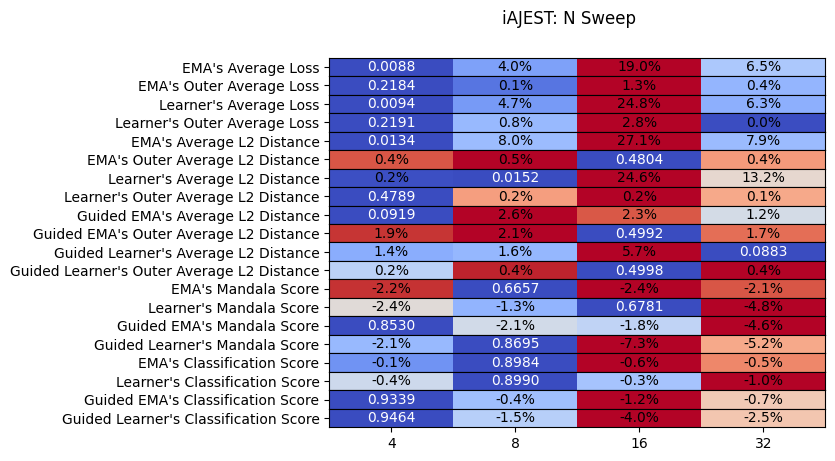

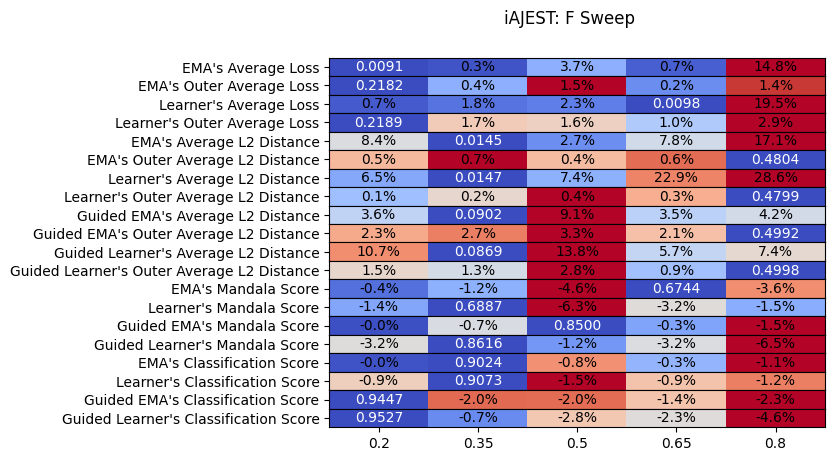

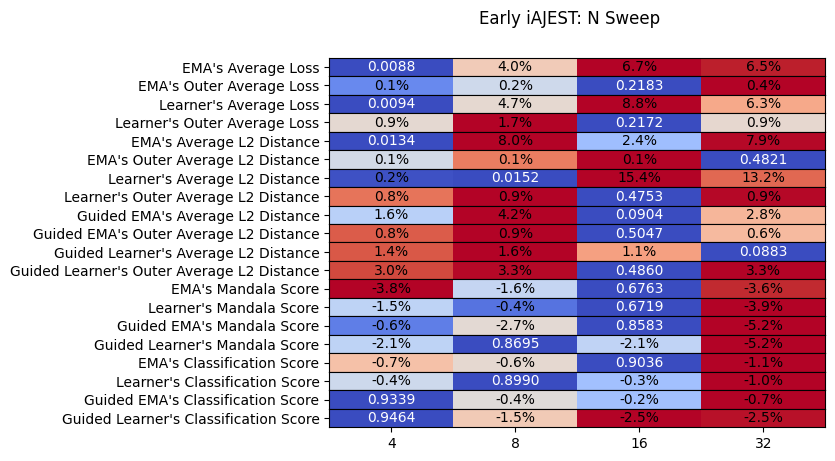

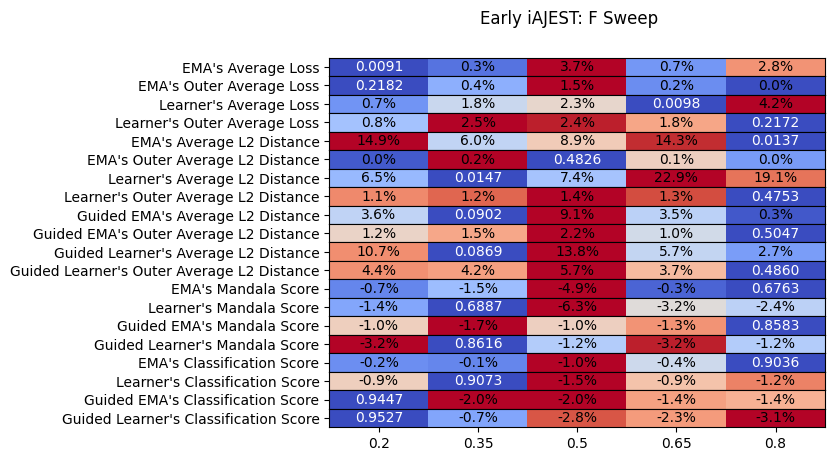

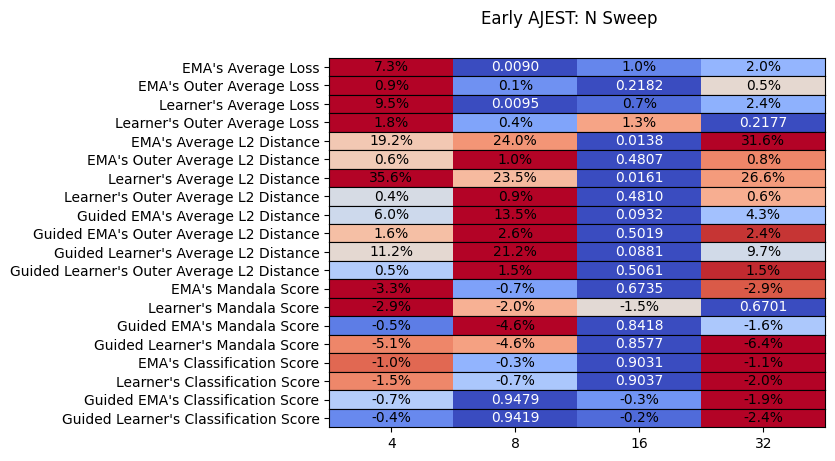

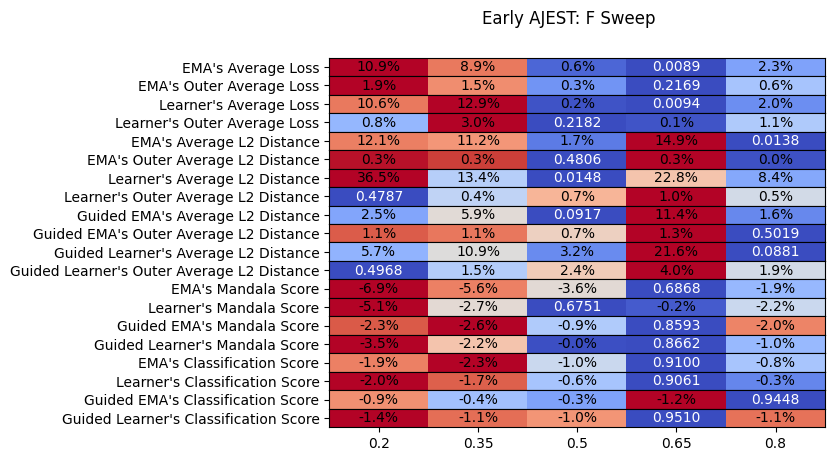

In [25]:
import warnings
warnings.filterwarnings("ignore")

show_values = True
show_percent = True

if show_values:
    aspect = "auto"
else: aspect = .5

param_test_keys = vtext.filter_by_string_must(test_keys, ["ref_","guide_"], must=False)

for s in param_series:
    for f in true_folders[s]:
        for param, values in zip(["N","F"], [N_values, F_values]):
            fig, axes = plt.subplots(nrows=len(param_test_keys), gridspec_kw=dict(hspace=0))
            plt.suptitle(true_labels[s][f] + ": " + param + " Sweep")
            for ax, k in zip(axes, param_test_keys):
                if "Score" in test_names[k]:
                    cmap = "coolwarm_r"
                    operation = max
                else: 
                    cmap = "coolwarm" # Blue is good, red is bad
                    operation = min
                ax.imshow(np.array(param_results[s][f][param][k]).reshape((1,len(values))), cmap=cmap, aspect=aspect)
                if show_values:
                    for idx, metric in enumerate(param_results[s][f][param][k]):
                        if metric == operation(param_results[s][f][param][k]):
                            color = "w"
                            metric = f"{metric:.4f}"
                        else: 
                            color = "k"
                            if show_percent: 
                                metric = metric/operation(param_results[s][f][param][k]) - 1
                                metric = f"{100*metric:.1f}%"
                            else:
                                metric = f"{metric:.4f}"
                        ax.text(idx, 0, metric, ha='center', va='center', color=color)
                ax.set_yticks([0],[test_names[k]])
            for i in range(len(axes)-1):
                axes[i].xaxis.set_visible(False)
            axes[-1].set_xticks(range(len(values)), values)